<a href="https://colab.research.google.com/github/Jasper-Hewitt/privatestuff/blob/main/ElectionSentiment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [1]:
!pip install datasets
!pip install transformers
!pip install --upgrade xlrd
!pip install huggingface_hub

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 452 kB 31.8 MB/s 
     |████████████████████████████████| 132 kB 6.3 MB/s 
     |████████████████████████████████| 212 kB 79.2 MB/s 
     |████████████████████████████████| 182 kB 77.2 MB/s 
     |████████████████████████████████| 127 kB 75.1 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 33.7 MB/s 
     |████████████████████████████████| 7.6 MB 67.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 96 kB 1.8 MB/s 
  Attempting uninstall: xlrd
    Found existing installation: xlrd 1.2.0
    Uninst

In [2]:
#import our model from huggingface
number_classes = 2
model_tokenizer = "hfl/chinese-roberta-wwm-ext"

if number_classes == 2:
    model_classifier = "Jiabo/Roberta_Chinese_sentiment"
else:
    model_classifier = "owen198/weibo-wmmbert-6"

In [3]:
model_classifier

'Jiabo/Roberta_Chinese_sentiment'

#1 黃珊珊

## 1.1 load and clean 黃珊珊 data

In [4]:
#insert new xlsx file here
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_shanshan.xlsx

--2022-12-21 08:49:29--  https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_shanshan.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 410939 (401K) [application/octet-stream]
Saving to: ‘scrap_shanshan.xlsx’

scrap_shanshan.xlsx 100%[===================>] 401.31K  --.-KB/s    in 0.003s  

2022-12-21 08:49:30 (144 MB/s) - ‘scrap_shanshan.xlsx’ saved [410939/410939]



In [5]:
import pandas as pd

In [6]:
#insert new xlsx file here
testing_pd = pd.read_excel('/content/scrap_shanshan.xlsx')
testing_pd = testing_pd[['Text']]
testing_pd = testing_pd.rename(columns={'Text':'text'})

In [7]:
#dirty data
testing_pd

,text
0,FelixChang 台灣獨立建國志願軍\n@FelixCh29980680\n·\n42m...
1,FelixChang 台灣獨立建國志願軍\n@FelixCh29980680\n·\n1h對...
2,Bruce Kuo\n@kuo1912\n·\n7hReplying to \n@i_don...
3,肯尼不啃泥\n@i_dont_care_004\n·\n8 Dec喔我確定那個男的是白粉，因...
4,ChenChen\n@Chen57962136\n·\n7 Dec[https://twit...
...,...
1683,Need a Drink\n@KmtEnemy\n·\n31 Oct林洲民基本上是我最討厭的...
1684,台灣推新聞\n@mytwnews\n·\n31 Oct嗆蔣萬安搞不清內湖科學園區狀況 黃珊珊...
1685,逆轟高灰\n@IloveROCTW\n·\n31 OctReplying to \n@byj...
1686,lemondemon\n@lemondemon\n·\n31 Oct轉噗 不來恩: 接到電話...


In [8]:
#we can consider not deleting the titles. This will be up to the ICI project group to decide
#if you wish to preserve the titles. replace the corresponding block of code below with this one 

#testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True)#.replace(title_pattern_1,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
##testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
#________________________________________________________________________________________________________________________

testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]


import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
#title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'
twitter_username='@([A-Za-z0-9_]+)'
letters='[A-z]'
newline_symbols='/\r?\n|\r/'
numbers='[0-9]'

#replace with this block. Do some more research because it looks like some titles are still removed, like index 41
testing_pd['text'] = testing_pd['text'].replace(twitter_username,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(letters,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(newline_symbols,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(numbers,'',regex=True)

In [9]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['text']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,text
0,台灣獨立建國志願軍\n\n·\n \n\n那陳時中可以去控告周玉蔻啊！\n他這時不告，什...
1,"台灣獨立建國志願軍\n\n·\n對手罵陳時中""謀財害命""，他不提告；\n對手抹黑陳時中和周..."
2,\n\n·\n \n\n黃珊珊也沒結婚吧
3,肯尼不啃泥\n\n·\n 喔我確定那個男的是白粉，因為他就是在我面前對我說「我好希望是黃珊珊...
4,\n\n·\n \n宅神說敗而不潰\n黃珊珊及台灣民眾黨要快點有各種社群系統互動\n\n感想...
...,...
1683,\n\n·\n 林洲民基本上是我最討厭的人之一，但只要問對問題，不惡意攻擊，我們不是都要...
1684,台灣推新聞\n\n·\n 嗆蔣萬安搞不清內湖科學園區狀況 黃珊珊：難怪政策常出笑話 - 自由...
1685,逆轟高灰\n\n·\n \n\n之前黃珊珊在北市大辦被轟，但是國中小辦沒問題，講好就好，...
1686,\n\n·\n 轉噗 不來恩: 接到電話唯一支持黃珊珊~ ()\n\n \n.\n接到電...


### 1.2.1 Tokenization

In [10]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [11]:
from transformers import AutoTokenizer

In [12]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

Downloading:   0%|          | 0.00/19.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/689 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/110k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/269k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [13]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [14]:
full_test_dataset = tokenized_datasets["test"]

## 1.2 preparing BERT


In [15]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=2)

Downloading:   0%|          | 0.00/958 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/409M [00:00<?, ?B/s]

In [16]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

<ipython-input-16-e1ee7db0da93>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


In [17]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

In [18]:
import numpy as np

## 1.3 prediction results


In [19]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1688
  Batch size = 8


In [20]:
pred

PredictionOutput(predictions=array([[ 3.6057487, -3.016045 ],
       [ 1.6087757, -0.9003846],
       [ 2.813133 , -2.0091522],
       ...,
       [ 3.2540631, -2.6238778],
       [ 1.5167663, -0.7985944],
       [ 3.4647515, -2.850327 ]], dtype=float32), label_ids=None, metrics={'test_runtime': 57.9047, 'test_samples_per_second': 29.151, 'test_steps_per_second': 3.644})

In [21]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [23]:
#final table. Remember, 0 = negative, 1 = positive
testing_pd

,text,pred
0,台灣獨立建國志願軍\n\n·\n \n\n那陳時中可以去控告周玉蔻啊！\n他這時不告，什...,0
1,"台灣獨立建國志願軍\n\n·\n對手罵陳時中""謀財害命""，他不提告；\n對手抹黑陳時中和周...",0
2,\n\n·\n \n\n黃珊珊也沒結婚吧,0
3,肯尼不啃泥\n\n·\n 喔我確定那個男的是白粉，因為他就是在我面前對我說「我好希望是黃珊珊...,1
4,\n\n·\n \n宅神說敗而不潰\n黃珊珊及台灣民眾黨要快點有各種社群系統互動\n\n感想...,1
...,...,...
1683,\n\n·\n 林洲民基本上是我最討厭的人之一，但只要問對問題，不惡意攻擊，我們不是都要...,0
1684,台灣推新聞\n\n·\n 嗆蔣萬安搞不清內湖科學園區狀況 黃珊珊：難怪政策常出笑話 - 自由...,0
1685,逆轟高灰\n\n·\n \n\n之前黃珊珊在北市大辦被轟，但是國中小辦沒問題，講好就好，...,0
1686,\n\n·\n 轉噗 不來恩: 接到電話唯一支持黃珊珊~ ()\n\n \n.\n接到電...,0


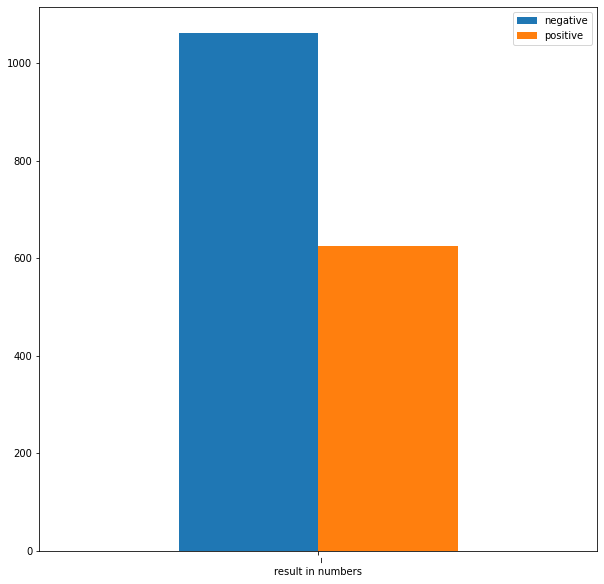

In [24]:
#plot in total amounts. Remember, 0 = negative, 1 = positive
import pandas as pd
import matplotlib.pyplot as plt
count0 = (testing_pd['pred'] == 0).sum()
count1 = (testing_pd['pred'] == 1).sum()
df_plot=pd.DataFrame({'result in numbers': ['_'], 'negative':[count0], 'positive': [count1]})
df_plot.plot.bar(x='result in numbers', figsize=(10, 10))
plt.show()

##1.3.1 piechart

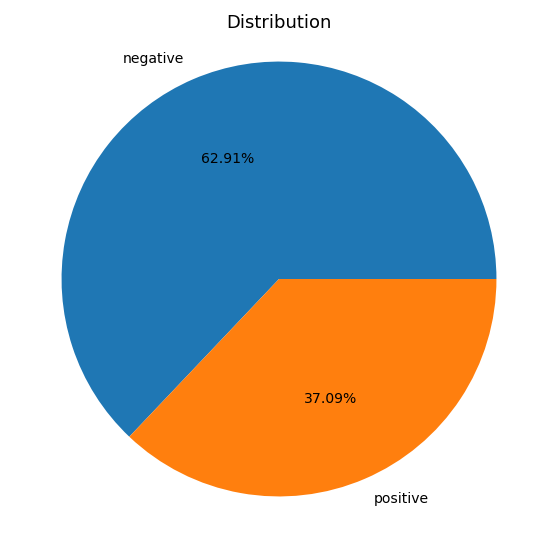

In [25]:
#plot in percentage. Remember, 0 = negative, 1 = positive
def Percentage(num1, num2):
    return num1 / (num1 + num2) * 100

per1=Percentage(count0, count1)
per2=Percentage(count1, count0)

label = ['negative', 'positive']
shares = [per1, per2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(shares, labels=label, autopct='%.2f%%', shadow=False, labeldistance=1.1,  textprops={'fontsize': 14})
ax.set_title('Distribution', fontsize=18, y=0.95);

#2 蔣萬安

## 2.1 load and clean 蔣萬安 data

In [26]:
#insert new xlsx file here
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_ChiangWanan.xlsx

--2022-12-21 08:51:18--  https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_ChiangWanan.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 323135 (316K) [application/octet-stream]
Saving to: ‘scrap_ChiangWanan.xlsx’

scrap_ChiangWanan.x 100%[===================>] 315.56K  --.-KB/s    in 0.008s  

2022-12-21 08:51:19 (38.6 MB/s) - ‘scrap_ChiangWanan.xlsx’ saved [323135/323135]



In [27]:
import pandas as pd

In [28]:
#insert new xlsx file here
testing_pd = pd.read_excel('/content/scrap_ChiangWanan.xlsx')
testing_pd = testing_pd[['Text']]
testing_pd = testing_pd.rename(columns={'Text':'text'})

In [29]:
#dirty data
testing_pd

,text
0,台灣推新聞\n@mytwnews\n·\n51m爆料北市府多人留任蔣萬安小內閣 柯大笑：代表...
1,Lu Authority Philosophy\n@archer_taiwan\n·\n1h...
2,鉅石會\n@GoldenRockTW\n·\n1h中共對台文攻武嚇，近年變本加厲備受國際關注...
3,吳奕軍 JasonWu\n@jasonbosox\n·\n1h中共對台文攻武嚇，近年變本加厲...
4,台灣大叔\n@XjxjjxDjdjdj\n·\n4hReplying to \n@Felix...
...,...
1471,台灣推新聞\n@mytwnews\n·\n18 Nov藍質疑曾赴中國醫學交流 陳時中競辦：轉...
1472,李俊賢\n@jimlee32\n·\n18 Nov on \n@YouTube\n: 辭立委...
1473,ysj Taiwan\n@tubbysong\n·\n18 Nov高虹安李忠庭列被告！高虹安...
1474,三立iNEWS\n@inewsknowledge\n·\n18 Nov辭立委喊喊而已？蔣萬安...


In [30]:
#we can consider not deleting the titles. This will be up to the ICI project group to decide
#if you wish to preserve the titles. replace the corresponding block of code below with this one 

#testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True)#.replace(title_pattern_1,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
##testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
#________________________________________________________________________________________________________________________

testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]


import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
#title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'
twitter_username='@([A-Za-z0-9_]+)'
letters='[A-z]'
newline_symbols='/\r?\n|\r/'
numbers='[0-9]'

#replace with this block. Do some more research because it looks like some titles are still removed, like index 41
testing_pd['text'] = testing_pd['text'].replace(twitter_username,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(letters,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(newline_symbols,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(numbers,'',regex=True)

In [31]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['text']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,text
0,台灣推新聞\n\n·\n爆料北市府多人留任蔣萬安小內閣 柯大笑：代表我的局處長太優秀 - 自...
1,\n\n·\n蔣萬安聽清楚了！\n:\n
2,鉅石會\n\n·\n中共對台文攻武嚇，近年變本加厲備受國際關注，台灣人抗中保台是天經地義。\...
3,吳奕軍 \n\n·\n中共對台文攻武嚇，近年變本加厲備受國際關注，台灣人抗中保台是天經地義。...
4,台灣大叔\n\n·\n \n\n要檢討個人，趁現在還可以自由說話，快點大力檢討。\n以後共...
...,...
1471,台灣推新聞\n\n·\n 藍質疑曾赴中國醫學交流 陳時中競辦：轉移蔣萬安矽谷經驗焦點 - 自...
1472,李俊賢\n\n·\n \n\n: 辭立委喊喊而已？蔣萬安拖天才完成辭職手續 楞好幾拍效率...
1473,\n\n·\n 高虹安李忠庭列被告！高虹安票太多嘲諷馬英九死亡之握？！台積電大舉投資棄台論...
1474,三立\n\n·\n 辭立委喊喊而已？蔣萬安拖天才完成辭職手續 楞好幾拍效率也太差！吹噓矽谷經...


### 2.1.1 Tokenization

In [32]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [33]:
from transformers import AutoTokenizer

In [34]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--hfl--chinese-roberta-wwm-ext/snapshots/5c58d0b8ec1d9014354d691c538661bf00bfdb44/config.json
Model config BertConfig {
  "_name_or_path": "hfl/chinese-roberta-wwm-ext",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "directionality": "bidi",
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.

In [35]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [36]:
full_test_dataset = tokenized_datasets["test"]

## 2.2 preparing BERT for 蔣萬安


In [37]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Jiabo--Roberta_Chinese_sentiment/snapshots/adbac307def959ebfdcc91ea16713ced4bb36c22/config.json
Model config BertConfig {
  "_name_or_path": "Jiabo/Roberta_Chinese_sentiment",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "directionality": "bidi",
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem

In [38]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [39]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [40]:
import numpy as np

## 2.3 prediction results 蔣萬安


In [41]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1476
  Batch size = 8


In [42]:
pred

PredictionOutput(predictions=array([[-2.1086917,  1.2203352],
       [-2.2582111,  1.3552265],
       [-2.7559295,  2.0173798],
       ...,
       [ 2.229121 , -1.4934417],
       [ 3.796947 , -3.208681 ],
       [ 2.2763026, -1.5114912]], dtype=float32), label_ids=None, metrics={'test_runtime': 46.2793, 'test_samples_per_second': 31.893, 'test_steps_per_second': 3.997})

In [43]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([1, 1, 1, ..., 0, 0, 0])

In [44]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [45]:
#final table. Remember, 0 = negative, 1 = positive
testing_pd

,text,pred
0,台灣推新聞\n\n·\n爆料北市府多人留任蔣萬安小內閣 柯大笑：代表我的局處長太優秀 - 自...,1
1,\n\n·\n蔣萬安聽清楚了！\n:\n,1
2,鉅石會\n\n·\n中共對台文攻武嚇，近年變本加厲備受國際關注，台灣人抗中保台是天經地義。\...,1
3,吳奕軍 \n\n·\n中共對台文攻武嚇，近年變本加厲備受國際關注，台灣人抗中保台是天經地義。...,1
4,台灣大叔\n\n·\n \n\n要檢討個人，趁現在還可以自由說話，快點大力檢討。\n以後共...,0
...,...,...
1471,台灣推新聞\n\n·\n 藍質疑曾赴中國醫學交流 陳時中競辦：轉移蔣萬安矽谷經驗焦點 - 自...,0
1472,李俊賢\n\n·\n \n\n: 辭立委喊喊而已？蔣萬安拖天才完成辭職手續 楞好幾拍效率...,0
1473,\n\n·\n 高虹安李忠庭列被告！高虹安票太多嘲諷馬英九死亡之握？！台積電大舉投資棄台論...,0
1474,三立\n\n·\n 辭立委喊喊而已？蔣萬安拖天才完成辭職手續 楞好幾拍效率也太差！吹噓矽谷經...,0


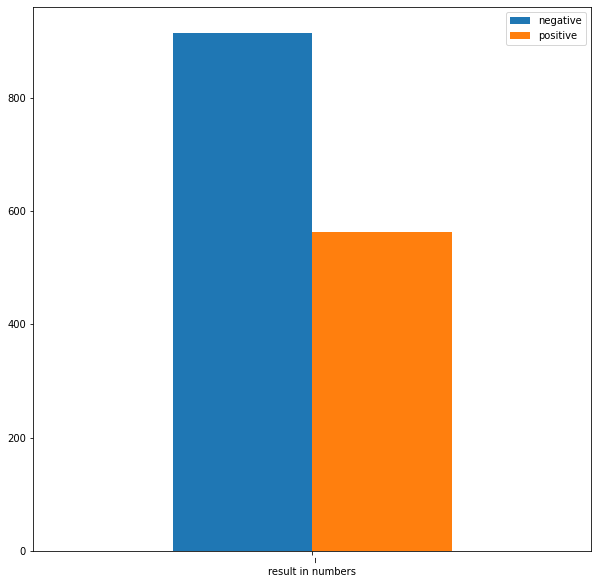

In [46]:
#plot in total amounts. Remember, 0 = negative, 1 = positive
import pandas as pd
import matplotlib.pyplot as plt
count0 = (testing_pd['pred'] == 0).sum()
count1 = (testing_pd['pred'] == 1).sum()
df_plot=pd.DataFrame({'result in numbers': ['_'], 'negative':[count0], 'positive': [count1]})
df_plot.plot.bar(x='result in numbers', figsize=(10, 10))
plt.show()

##2.3.1 piechart

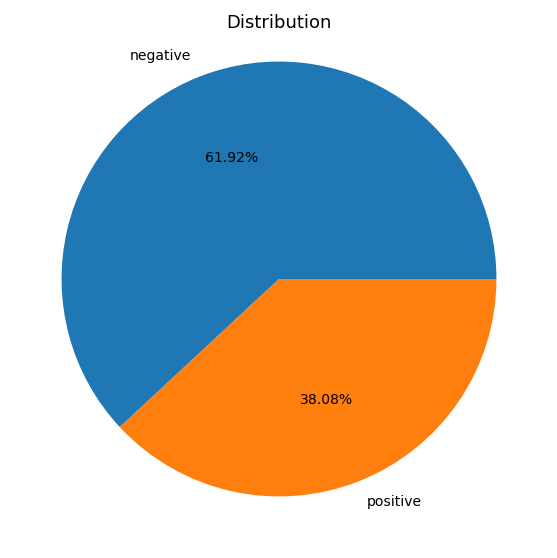

In [47]:
#plot in percentage. Remember, 0 = negative, 1 = positive
def Percentage(num1, num2):
    return num1 / (num1 + num2) * 100

per1=Percentage(count0, count1)
per2=Percentage(count1, count0)

label = ['negative', 'positive']
shares = [per1, per2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(shares, labels=label, autopct='%.2f%%', shadow=False, labeldistance=1.1,  textprops={'fontsize': 14})
ax.set_title('Distribution', fontsize=18, y=0.95);

#3 陳時中

## 3.1 load and clean data

In [48]:
#insert new xlsx file here
! wget -nc https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_chenshichung.xlsx

--2022-12-21 08:52:12--  https://raw.githubusercontent.com/advapplab/sentiment_analysis_election_2022/main/data/jasper/scrap_chenshichung.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 424461 (415K) [application/octet-stream]
Saving to: ‘scrap_chenshichung.xlsx’

scrap_chenshichung. 100%[===================>] 414.51K  --.-KB/s    in 0.004s  

2022-12-21 08:52:12 (101 MB/s) - ‘scrap_chenshichung.xlsx’ saved [424461/424461]



In [49]:
import pandas as pd

In [50]:
#insert new xlsx file here
testing_pd = pd.read_excel('/content/scrap_chenshichung.xlsx')
testing_pd = testing_pd[['Text']]
testing_pd = testing_pd.rename(columns={'Text':'text'})

In [51]:
#dirty data
testing_pd

,text
0,FelixChang 台灣獨立建國志願軍\n@FelixCh29980680\n·\n11m...
1,Dshunter52 專職獵人\n@dshunter52\n·\n36mReplying t...
2,夜巡\n@aazz3738\n·\n1h陳時中初入江湖不求勝招卻想著求敗的境界\n太清高的人...
3,Romeolucian Popa\n@RomeolucianP\n·\n1h吳怡農陳時中姚文...
4,Yang Hsun Cheng\n@YShihjung\n·\n1h黑道教父黃承國，柯文哲蔡...
...,...
1945,風の翅膀\n@philden612\n·\n23 Nov翻譯的太傳神了。\n\n#民進黨\n...
1946,Ironforces\n@Ironforces1\n·\n23 NovReplying to...
1947,uno\n@ap323301\n·\n23 Nov我有兩個願望\n台北市陳時中要贏\n新竹市...
1948,SirCharles\n@SirCharles1228\n·\n23 NovReplying...


In [52]:
#we can consider not deleting the titles. This will be up to the ICI project group to decide
#if you wish to preserve the titles. replace the corresponding block of code below with this one 

#testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True)#.replace(title_pattern_1,'',regex=True)
#testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
##testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
#________________________________________________________________________________________________________________________

testing_pd = testing_pd[~testing_pd['text'].str.contains('a href', regex=True)]


import re
html_pattern = "<(?:\"[^\"]*\"['\"]*|'[^']*'['\"]*|[^'\">])+>"
http_pattern = "http\S+"
image_pattern = "<img\s[^>]*?src\s*=\s*['\"]([^'\"]*?)['\"][^>]*?>" 
#title_pattern = "[【|《*】|》]"
title_pattern_1 = "(?=【)(.*)(?<=】)"
title_pattern_2 = "(?=《)(.*)(?<=》)"
link_pattern="网页链接"
span_pattern='<span.*?>(.+?)</span>'
twitter_username='@([A-Za-z0-9_]+)'
letters='[A-z]'
newline_symbols='/\r?\n|\r/'
numbers='[0-9]'

#replace with this block. Do some more research because it looks like some titles are still removed, like index 41
testing_pd['text'] = testing_pd['text'].replace(twitter_username,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(span_pattern,'',regex=True).replace(span_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(http_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(image_pattern,'',regex=True).replace(title_pattern_1,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(link_pattern,'',regex=True).replace(html_pattern,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(title_pattern_2,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(letters,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(newline_symbols,'',regex=True)
testing_pd['text'] = testing_pd['text'].replace(numbers,'',regex=True)

In [53]:
#delete empty rows
testing_pd = testing_pd[testing_pd['text'].str.len()>2]   
testing_pd = testing_pd[['text']]
testing_pd = testing_pd.reset_index(drop=True)
testing_pd

,text
0,"台灣獨立建國志願軍\n\n·\n陳時中敗選後\n只扔下敗選者的通用語""是我不夠努力""\n就..."
1,專職獵人\n\n·\n \n\n所以你有把握如果陳時中每天去聽早會，強力反擊對手，堵麥時...
2,夜巡\n\n·\n陳時中初入江湖不求勝招卻想著求敗的境界\n太清高的人真的不適合闖江湖(政治...
3,\n\n·\n吳怡農陳時中姚文智三合一 綠大老嘆蔡英文黨末日膏肓 新聞大白話 \n\...
4,\n\n·\n黑道教父黃承國，柯文哲蔡英文呂秀蓮陳時中姚文智黃珊珊都倚重。影響台灣政治的...
...,...
1945,風の翅膀\n\n·\n 翻譯的太傳神了。\n\n#民進黨\n#蔡英文\n#陳時中\n#蔡適應...
1946,\n\n·\n \n\n瓜級本來就天天的\n天龍的那種天\n有時可以不用太理他\n但是\...
1947,\n\n·\n 我有兩個願望\n台北市陳時中要贏\n新竹市高虹安要輸\n這兩個沒有實現我會崩...
1948,\n\n·\n \n\n罵推友就算了，看了陳時中的說明什麼都沒弄懂就亂批一通，真的出一張...


### 3.1.2 Tokenization

In [54]:
from datasets import Dataset, DatasetDict

weibo_dict = {
              'test' : Dataset.from_pandas(testing_pd)}

weibo_ds = DatasetDict(weibo_dict)

In [55]:
from transformers import AutoTokenizer

In [56]:
tokenizer = AutoTokenizer.from_pretrained(model_tokenizer)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--hfl--chinese-roberta-wwm-ext/snapshots/5c58d0b8ec1d9014354d691c538661bf00bfdb44/config.json
Model config BertConfig {
  "_name_or_path": "hfl/chinese-roberta-wwm-ext",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "directionality": "bidi",
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "transformers_version": "4.25.

In [57]:
def tokenize_function(examples):
    return tokenizer(examples["text"], 
                     padding="max_length", 
                     truncation=True, 
                     max_length=512)

tokenized_datasets = weibo_ds.map(tokenize_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

In [58]:
full_test_dataset = tokenized_datasets["test"]

## 3.2 preparing BERT


In [59]:
from transformers import AutoModelForSequenceClassification

# available chinese models: https://github.com/ymcui/Chinese-BERT-wwm

model = AutoModelForSequenceClassification.from_pretrained(model_classifier, 
                                                           num_labels=2)

loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--Jiabo--Roberta_Chinese_sentiment/snapshots/adbac307def959ebfdcc91ea16713ced4bb36c22/config.json
Model config BertConfig {
  "_name_or_path": "Jiabo/Roberta_Chinese_sentiment",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "directionality": "bidi",
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "position_embedding_type": "absolute",
  "problem

In [60]:
from datasets import load_metric

metric = load_metric("accuracy")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [61]:
from transformers import Trainer

trainer = Trainer(
    model=model, 
    eval_dataset=full_test_dataset,
    compute_metrics=compute_metrics,
)

No `TrainingArguments` passed, using `output_dir=tmp_trainer`.
PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [62]:
import numpy as np

##3.3 prediction results


In [63]:
pred = trainer.predict(test_dataset=full_test_dataset)

The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 1950
  Batch size = 8


In [64]:
pred

PredictionOutput(predictions=array([[ 3.4589741, -2.9035943],
       [ 2.0306184, -1.2762731],
       [ 3.7206752, -3.1717129],
       ...,
       [ 2.9403117, -2.2355855],
       [ 3.884497 , -3.3252454],
       [-0.954429 ,  0.9170024]], dtype=float32), label_ids=None, metrics={'test_runtime': 61.4905, 'test_samples_per_second': 31.712, 'test_steps_per_second': 3.968})

In [65]:
# logits, labels = pred.predictions
np.argmax(pred.predictions, axis=-1)

array([0, 0, 0, ..., 0, 0, 1])

In [66]:
testing_pd['pred'] = np.argmax(pred.predictions, axis=-1)

In [67]:
#final table. Remember, 0 = negative, 1 = positive
testing_pd

,text,pred
0,"台灣獨立建國志願軍\n\n·\n陳時中敗選後\n只扔下敗選者的通用語""是我不夠努力""\n就...",0
1,專職獵人\n\n·\n \n\n所以你有把握如果陳時中每天去聽早會，強力反擊對手，堵麥時...,0
2,夜巡\n\n·\n陳時中初入江湖不求勝招卻想著求敗的境界\n太清高的人真的不適合闖江湖(政治...,0
3,\n\n·\n吳怡農陳時中姚文智三合一 綠大老嘆蔡英文黨末日膏肓 新聞大白話 \n\...,1
4,\n\n·\n黑道教父黃承國，柯文哲蔡英文呂秀蓮陳時中姚文智黃珊珊都倚重。影響台灣政治的...,1
...,...,...
1945,風の翅膀\n\n·\n 翻譯的太傳神了。\n\n#民進黨\n#蔡英文\n#陳時中\n#蔡適應...,1
1946,\n\n·\n \n\n瓜級本來就天天的\n天龍的那種天\n有時可以不用太理他\n但是\...,1
1947,\n\n·\n 我有兩個願望\n台北市陳時中要贏\n新竹市高虹安要輸\n這兩個沒有實現我會崩...,0
1948,\n\n·\n \n\n罵推友就算了，看了陳時中的說明什麼都沒弄懂就亂批一通，真的出一張...,0


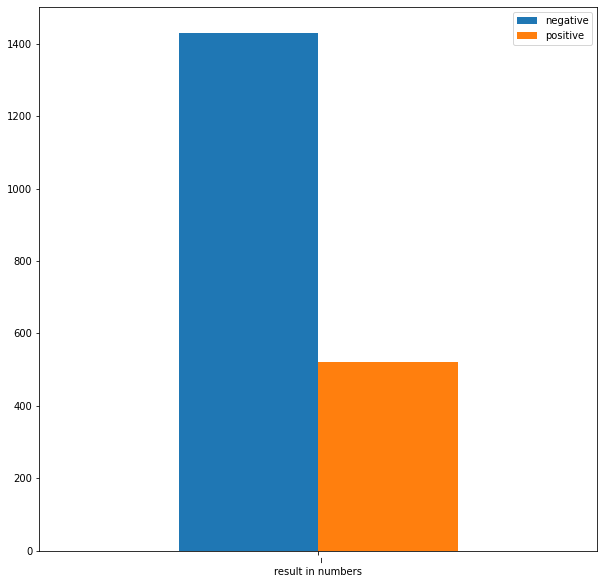

In [68]:
#plot in total amounts. Remember, 0 = negative, 1 = positive
import pandas as pd
import matplotlib.pyplot as plt
count0 = (testing_pd['pred'] == 0).sum()
count1 = (testing_pd['pred'] == 1).sum()
df_plot=pd.DataFrame({'result in numbers': ['_'], 'negative':[count0], 'positive': [count1]})
df_plot.plot.bar(x='result in numbers', figsize=(10, 10))
plt.show()

##3.3.1 piechart

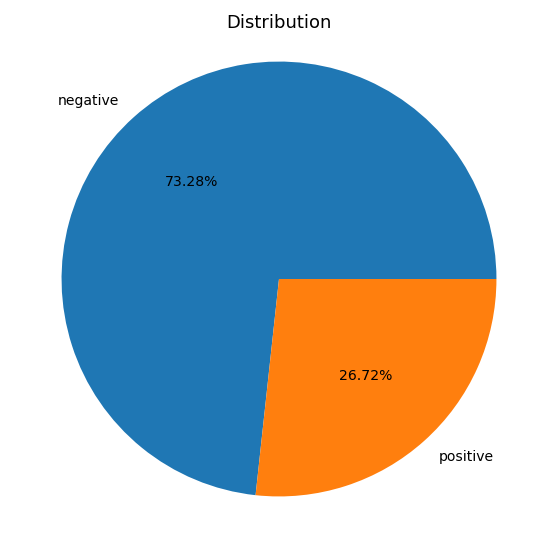

In [70]:
#plot in percentage. Remember, 0 = negative, 1 = positive
def Percentage(num1, num2):
    return num1 / (num1 + num2) * 100

per1=Percentage(count0, count1)
per2=Percentage(count1, count0)

label = ['negative', 'positive']
shares = [per1, per2]
fig, ax = plt.subplots(figsize=(10,10))
ax.pie(shares, labels=label, autopct='%.2f%%', shadow=False, labeldistance=1.1,  textprops={'fontsize': 14})
ax.set_title('Distribution', fontsize=18, y=0.95);

# add bonus 高虹安？

#5 comparison, put charts next to each other